In [76]:
# Стандартна бібліотека
import os
import sys
import time
import itertools
import json
import random
from pathlib import Path
from typing import Union
from dataclasses import dataclass
from collections import defaultdict, Counter
from typing import Any, Dict, List, Optional, Tuple
import zipfile

# Наукові обчислення та табличні дані
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Візуалізація
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

# Комп'ютерний зір та зображення
import cv2
from PIL import Image
from IPython.display import display

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils import clip_grad_norm_
import torch.amp

# Аугментації
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Перевірка CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"torch current device: {torch.cuda.current_device()}")
print(f"Training device: {device}")


PyTorch version: 2.10.0+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060
CUDA version: 13.0
torch current device: 0
Training device: cuda:0


```
#!/bin/bash
curl -L -o ~/Downloads/div2k-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/joe1995/div2k-dataset

```

```
  https://www.kaggle.com/competitions/denoising-dirty-documents/data
```

In [77]:
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "data"

# Шляхи до даних
DENOISING_DIR = DATA_DIR / "denoising-dirty-documents"
DIV2K_DIR = DATA_DIR / "div2k-dataset"

# Шляхи до zip-архівів
TARGET_ZIPS = [
    ROOT_DIR / "denoising-dirty-documents.zip",
    ROOT_DIR / "div2k-dataset.zip"
]

# Створення основної папки для даних
DATA_DIR.mkdir(exist_ok=True)

# --- Функції для обробки архівів ---

def unzip_recursive(zip_path: Path, extract_to: Path):
    """
    Розархівовує zip-файл у вказану папку, якщо папка призначення
    не існує або порожня.
    """
    if not zip_path.exists():
        print(f"Zip-файл не знайдено: {zip_path.name}")
        return

    if extract_to.exists() and any(extract_to.iterdir()):
        print(f"Папка {extract_to.name} вже існує і не порожня. Пропускаємо розархівацію.")
        return

    extract_to.mkdir(parents=True, exist_ok=True)
    try:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extract_to)
            print(f"Архів {zip_path.name} успішно розархівовано у {extract_to.name}")
    except zipfile.BadZipFile:
        print(f"Пропущено пошкоджений zip-файл: {zip_path.name}")
        return

    if zip_path.is_relative_to(DATA_DIR) and zip_path.exists():
        zip_path.unlink()

def process_zips(base_data_dir: Path):
    """
    Рекурсивно шукає вкладені zip-архіви та розархівовує їх.
    """
    found_zip = True
    while found_zip:
        found_zip = False
        for root, _, files in os.walk(base_data_dir):
            for file in files:
                if file.endswith('.zip'):
                    z_path = Path(root) / file
                    ex_path = Path(root) / z_path.stem
                    print(f"Знайдено вкладений архів {z_path.name}, розархівація у {ex_path.name}")
                    unzip_recursive(z_path, ex_path)
                    found_zip = True
                    break
            if found_zip:
                break

def flatten_duplicate_dirs(base_path: Path):
    """
    Піднімає файли на рівень вище, якщо папка та вкладена в неї папка
    мають однакові імена (щоб не було ../test/test/img).
    """
    flattened_something = True
    while flattened_something:
        flattened_something = False
        for root, dirs, _ in os.walk(base_path, topdown=False):
            current_dir = Path(root)
            if not current_dir.exists() or current_dir == base_path:
                continue
            
            for d in dirs:
                if d == current_dir.name:
                    child_dir = current_dir / d
                    if child_dir.exists() and child_dir.is_dir():
                        print(f"Злиття папок з однаковим ім'ям: {child_dir.name} -> {current_dir.name}")
                        for item in child_dir.iterdir():
                            dest_path = current_dir / item.name
                            try:
                                shutil.move(str(item), str(dest_path))
                            except shutil.Error as e:
                                print(f"Помилка переміщення {item.name} до {dest_path.name}: {e}")

                        try:
                            child_dir.rmdir()
                            flattened_something = True
                        except OSError as e:
                            print(f"Не вдалося видалити {child_dir.name}: {e}")
            if flattened_something:
                break

In [78]:
# 1. Витягуємо кореневі архіви
for z_path in TARGET_ZIPS:
    if z_path.exists():
        ex_path = DATA_DIR / z_path.stem
        print(f"Розархівація кореневого архіву {z_path.name} у {ex_path.name}")
        unzip_recursive(z_path, ex_path)
    else:
        print(f"Файл не знайдено (або вже розпаковано і видалено): {z_path.name}")
        
# 2. Шукаємо та розархівовуємо вкладені zip (рекурсивний розархіватор)
process_zips(DATA_DIR)

# 3. Позбавляємося вкладеностей типу test/test
flatten_duplicate_dirs(DATA_DIR)
print("Розархівацію та структурування успішно завершено!")

Розархівація кореневого архіву denoising-dirty-documents.zip у denoising-dirty-documents
Папка denoising-dirty-documents вже існує і не порожня. Пропускаємо розархівацію.
Розархівація кореневого архіву div2k-dataset.zip у div2k-dataset
Папка div2k-dataset вже існує і не порожня. Пропускаємо розархівацію.
Розархівацію та структурування успішно завершено!


In [79]:

DENOISING_TRAIN_DIR = DENOISING_DIR / "train"
DENOISING_TEST_DIR = DENOISING_DIR / "test"
DENOISING_CLEANED_DIR = DENOISING_DIR / "train_cleaned"
DENOISING_SAMPLESUBMISSIONCSV = DENOISING_DIR / "sampleSubmission.csv"
DIV2K_TRAIN_HR_DIR = DIV2K_DIR / "DIV2K_train_HR"
DIV2K_VALID_HR_DIR = DIV2K_DIR / "DIV2K_valid_HR"


In [80]:

# ── Конфігурація датасетів ─────────────────────────────────────────────
PATCH_SIZE   = 256        # розмір кропу (H x W)
SCALE        = 1          # 1 = той самий розмір (denoising / restoration)
VAL_SPLIT    = 0.1        # частка валідаційних зображень
RANDOM_SEED  = 42
BATCH_SIZE   = 8
NUM_WORKERS  = 4

IMG_EXTENSIONS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def gather_images(folder: Path) -> List[Path]:
    """Рекурсивно збирає всі зображення у папці."""
    return sorted(
        p for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTENSIONS
    )

def make_split(
    files: List[Path],
    val_ratio: float = VAL_SPLIT,
    seed: int = RANDOM_SEED,
) -> Tuple[List[Path], List[Path]]:
    """Детерміноване перемішування та розбивка на train / val."""
    rng = random.Random(seed)
    shuffled = files.copy()
    rng.shuffle(shuffled)
    n_val = max(1, int(len(shuffled) * val_ratio))
    return shuffled[n_val:], shuffled[:n_val]     # (train, val)


In [81]:

# ── Синтетична деградація для DIV2K ──────────────────────────────────
def apply_degradation(img: np.ndarray) -> np.ndarray:
    """
    Застосовує випадковий набір деградацій до RGB-зображення (uint8).

    Деградації (кожна застосовується незалежно з певною ймовірністю):
      • Gaussian noise
      • Gaussian blur
      • JPEG-артефакти
      • Downscale → Upscale (пікселізація)
    """
    out = img.copy()

    # Gaussian noise
    if random.random() < 0.8:
        sigma = random.uniform(5, 50)
        noise = np.random.normal(0, sigma, out.shape).astype(np.float32)
        out = np.clip(out.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Gaussian blur
    if random.random() < 0.5:
        ksize = random.choice([3, 5, 7])
        out = cv2.GaussianBlur(out, (ksize, ksize), 0)

    # JPEG compression
    if random.random() < 0.5:
        quality = random.randint(10, 60)
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, enc = cv2.imencode(".jpg", out, encode_param)
        out = cv2.imdecode(enc, cv2.IMREAD_COLOR)

    # Downscale → Upscale
    if random.random() < 0.3:
        h, w = out.shape[:2]
        factor = random.choice([2, 4])
        small = cv2.resize(out, (w // factor, h // factor), interpolation=cv2.INTER_AREA)
        out   = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)

    return out


# ── DIV2K Degraded Dataset ────────────────────────────────────────────
class DIV2KDegradedDataset(Dataset):
    """
    Повертає пару (noisy, clean) для синтетичної задачі відновлення.

    Із кожного чистого HR-зображення DIV2K вирізається патч;
    потім до нього застосовуються синтетичні деградації.
    Інтерфейс сумісний із DenoisingDataset: ключі 'noisy' і 'clean'.

    Параметри
    ----------
    files        : список шляхів до HR-зображень
    patch_size   : розмір кропу
    augment      : якщо True — застосовуються flip/rotate аугментації
    grayscale    : True → виводить 1-канальні тензори (як у DenoisingDataset)
    """

    def __init__(
        self,
        files: List[Path],
        patch_size: int = PATCH_SIZE,
        augment: bool = True,
        grayscale: bool = False,
    ):
        self.files      = files
        self.patch_size = patch_size
        self.augment    = augment
        self.grayscale  = grayscale

        self._aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ]) if augment else None

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        img_bgr = cv2.imread(str(self.files[idx]))
        clean   = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # random crop
        h, w = clean.shape[:2]
        ps   = self.patch_size
        if h > ps and w > ps:
            y     = random.randint(0, h - ps)
            x     = random.randint(0, w - ps)
            clean = clean[y : y + ps, x : x + ps]
        else:
            clean = cv2.resize(clean, (ps, ps), interpolation=cv2.INTER_AREA)

        # flip / rotate
        if self._aug:
            clean = self._aug(image=clean)["image"]

        # синтетична деградація на копії
        noisy = apply_degradation(clean)

        if self.grayscale:
            clean = cv2.cvtColor(clean, cv2.COLOR_RGB2GRAY)[..., None]
            noisy = cv2.cvtColor(noisy, cv2.COLOR_RGB2GRAY)[..., None]

        clean_t = torch.from_numpy(clean).permute(2, 0, 1).float() / 255.0
        noisy_t = torch.from_numpy(noisy).permute(2, 0, 1).float() / 255.0

        return {"noisy": noisy_t, "clean": clean_t}


# ── Denoising Dataset ─────────────────────────────────────────────────
class DenoisingDataset(Dataset):
    """
    Повертає пару (noisy, clean) для задачі відновлення документів.

    Параметри
    ----------
    noisy_files : список шляхів до зашумлених зображень
    clean_dir   : папка з відповідними «чистими» зображеннями
    patch_size  : розмір кропу (0 = без кропу, повне зображення)
    augment     : якщо True — flip/rotate аугментації
    """

    def __init__(
        self,
        noisy_files: List[Path],
        clean_dir: Path,
        patch_size: int = PATCH_SIZE,
        augment: bool = False,
    ):
        self.pairs: List[Tuple[Path, Path]] = []
        for nf in noisy_files:
            cf = clean_dir / nf.name
            if cf.exists():
                self.pairs.append((nf, cf))

        self.patch_size = patch_size
        self._aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ], additional_targets={"clean": "image"}) if augment else None

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        noisy_path, clean_path = self.pairs[idx]

        noisy = cv2.imread(str(noisy_path), cv2.IMREAD_GRAYSCALE)
        clean = cv2.imread(str(clean_path), cv2.IMREAD_GRAYSCALE)

        # спільний crop
        combined = np.stack([noisy, clean], axis=-1)
        ps = self.patch_size
        if ps and combined.shape[0] > ps and combined.shape[1] > ps:
            h, w = combined.shape[:2]
            y = random.randint(0, h - ps)
            x = random.randint(0, w - ps)
            combined = combined[y : y + ps, x : x + ps]

        noisy_out = combined[..., 0:1]
        clean_out = combined[..., 1:2]

        if self._aug:
            aug     = self._aug(image=noisy_out, clean=clean_out)
            noisy_t = torch.from_numpy(aug["image"]).permute(2, 0, 1)
            clean_t = torch.from_numpy(aug["clean"]).permute(2, 0, 1)
        else:
            noisy_t = torch.from_numpy(noisy_out).permute(2, 0, 1)
            clean_t = torch.from_numpy(clean_out).permute(2, 0, 1)

        return {
            "noisy": noisy_t.float() / 255.0,
            "clean": clean_t.float() / 255.0,
        }


In [ ]:

# ── Спліт DIV2K_TRAIN_HR → синтетичний датасет ───────────────────────
div2k_all_files   = gather_images(DIV2K_TRAIN_HR_DIR)
div2k_train_files, div2k_val_files = make_split(div2k_all_files)

print(f"DIV2K total : {len(div2k_all_files):>4}")
print(f"  train     : {len(div2k_train_files):>4}")
print(f"  val       : {len(div2k_val_files):>4}")

# ── Спліт Denoising (реальні пари) ───────────────────────────────────
denoising_noisy_all       = gather_images(DENOISING_TRAIN_DIR)
den_train_noisy, den_val_noisy = make_split(denoising_noisy_all)

print(f"\nDenoising total : {len(denoising_noisy_all):>4}")
print(f"  train         : {len(den_train_noisy):>4}")
print(f"  val           : {len(den_val_noisy):>4}")

# ── Інстанціювання датасетів ──────────────────────────────────────────
ds_div2k_train = DIV2KDegradedDataset(div2k_train_files, augment=True,  grayscale=False)
ds_div2k_val   = DIV2KDegradedDataset(div2k_val_files,   augment=False, grayscale=False)

ds_den_train   = DenoisingDataset(den_train_noisy, DENOISING_CLEANED_DIR, augment=True)
ds_den_val     = DenoisingDataset(den_val_noisy,   DENOISING_CLEANED_DIR, augment=False)

print(f"\nDIV2K degraded train : {len(ds_div2k_train)} samples")
print(f"DIV2K degraded val   : {len(ds_div2k_val)}   samples")
print(f"Denoising train      : {len(ds_den_train)} samples")
print(f"Denoising val        : {len(ds_den_val)}   samples")

# ── DataLoaders ───────────────────────────────────────────────────────
# Python 3.14 на Linux змінив дефолтний метод multiprocessing на
# 'forkserver', який не може серіалізувати класи з ноутбука.
# multiprocessing_context='fork' — worker-и успадковують пам'ять
# батьківського процесу разом з усіма визначеними класами.
# https://docs.pytorch.org/docs/stable/notes/windows.html#usage-multiprocessing
_MP_CTX = "fork"

dl_div2k_train = DataLoader(ds_div2k_train, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
                            multiprocessing_context=_MP_CTX)
dl_div2k_val   = DataLoader(ds_div2k_val,   batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True,
                            multiprocessing_context=_MP_CTX)

dl_den_train   = DataLoader(ds_den_train, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
                            multiprocessing_context=_MP_CTX)
dl_den_val     = DataLoader(ds_den_val,   batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True,
                            multiprocessing_context=_MP_CTX)

print("\nDataLoaders готові ✓")


DIV2K total :  800
  train     :  720
  val       :   80

Denoising total :  144
  train         :  130
  val           :   14

DIV2K degraded train : 720 samples
DIV2K degraded val   : 80   samples
Denoising train      : 130 samples
Denoising val        : 14   samples


DIV2K degraded
  noisy : (8, 3, 256, 256)  dtype=torch.float32  range=[0.00, 1.00]
  clean : (8, 3, 256, 256)  dtype=torch.float32  range=[0.00, 1.00]
Denoising
  noisy : (8, 1, 256, 256)  dtype=torch.float32  range=[0.00, 1.00]
  clean : (8, 1, 256, 256)  dtype=torch.float32  range=[0.00, 1.00]


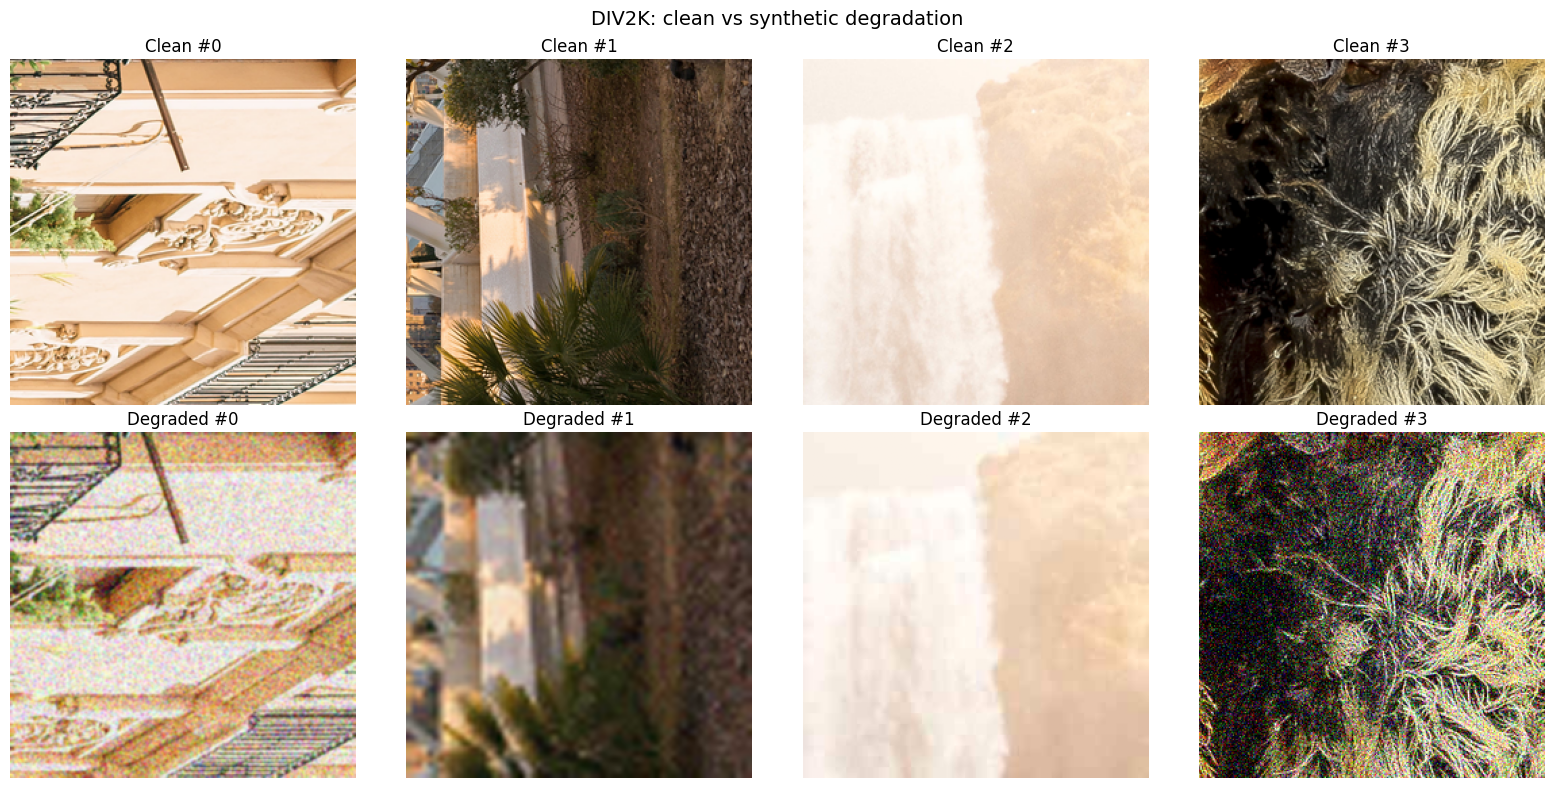

In [83]:

# ── Санітарна перевірка батчів ────────────────────────────────────────
batch_div2k = next(iter(dl_div2k_train))
batch_den   = next(iter(dl_den_train))

for name, batch in [("DIV2K degraded", batch_div2k), ("Denoising", batch_den)]:
    n  = batch["noisy"]
    c  = batch["clean"]
    print(f"{name}")
    print(f"  noisy : {tuple(n.shape)}  dtype={n.dtype}  range=[{n.min():.2f}, {n.max():.2f}]")
    print(f"  clean : {tuple(c.shape)}  dtype={c.dtype}  range=[{c.min():.2f}, {c.max():.2f}]")

# Візуалізація кількох прикладів із DIV2K
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    noisy_np = batch_div2k["noisy"][i].permute(1, 2, 0).numpy()
    clean_np = batch_div2k["clean"][i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(np.clip(clean_np, 0, 1))
    axes[0, i].set_title(f"Clean #{i}")
    axes[0, i].axis("off")
    axes[1, i].imshow(np.clip(noisy_np, 0, 1))
    axes[1, i].set_title(f"Degraded #{i}")
    axes[1, i].axis("off")
plt.suptitle("DIV2K: clean vs synthetic degradation", fontsize=14)
plt.tight_layout()
plt.show()
